# Блокнот для изучения метода генерации полей

Цель блокнота - сгенерировать fractional Brownian motion (fBm) — случайное поле с фрактальной структурой и заданным показателем Хёрста $H$.

### Схема процесса

```
Белый шум (Fourier)
        ↓
Степенной фильтр |k|^{-(H + d/2)}
        ↓
Обратное FFT
        ↓
fractional Brownian motion
```

### 1. Белый шум в Фурье-пространстве

Формируем белый гауссов шум:

$
\hat{\xi}(\mathbf{k}) = \xi_1(\mathbf{k}) + i,\xi_2(\mathbf{k}),
\quad
\xi_1, \xi_2 \sim \mathcal{N}(0,1)
$

Свойство белого шума:

$
\mathbb{E}|\hat{\xi}(\mathbf{k})|^2 = \text{const}
$


### 2. Пространство волновых чисел

Каждой частоте Фурье соответствует вектор:

$
\mathbf{k} = (k_1, \dots, k_d)
$

и его длина:

$
|\mathbf{k}| = \sqrt{k_1^2 + \dots + k_d^2}
$


### 3. Степенной спектр fBm

Для fractional Brownian motion в размерности $d$ спектральная плотность мощности имеет вид:

$
P_{\text{fBm}}(\mathbf{k})
;\propto;
|\mathbf{k}|^{-(2H + d)}
$

где:

* $H \in (0,1)$ — показатель Хёрста
* $d$ — размерность пространства


### 4. Амплитудный фильтр

Так как умножаеся амплитуда, а не мощность, используется корень:

$
S(\mathbf{k}) ;\propto;
|\mathbf{k}|^{-(H + d/2)}
$

И формируем сигнал - окрашенный белый шум:

$
\hat{u}(\mathbf{k}) = S(\mathbf{k}) \cdot \hat{\xi}(\mathbf{k})
$

### 5. Нулевая частота

В точке $\mathbf{k} = 0$:

$
|\mathbf{k}|^{-(H + d/2)} \to \infty
$

Поэтому мы принудительно задаём: $\hat{u}(0) = 0$, чтобы устранить расходимость и зафиксировать среднее значение поля.


### 6. Обратное преобразование Фурье

Теперь выполняем обратное преобразование Фурье:

$
u(\mathbf{x}) =
\mathcal{F}^{-1}
\left[
\hat{\xi}(\mathbf{k}),|\mathbf{k}|^{-(H + d/2)}
\right]
$

Результатом будет **fractional Brownian motion**.

### **Источники**:

* Dietrich & Newsam (1997),
  *Fast and Exact Simulation of Stationary Gaussian Processes through Circulant Embedding of the Covariance Matrix*
  [https://doi.org/10.1137/S1064827592240555](https://doi.org/10.1137/S1064827592240555)

* Mandelbrot & Van Ness (1968),
  *Fractional Brownian motions, fractional noises and applications*
  [https://doi.org/10.1137/1010093](https://doi.org/10.1137/1010093)

### Нормировка

Чаще всего поле масштабируют, это обеспечивает универсальность метода в экспериментах. Для этого в функции `ndfnoise` есть параметр `normalize`, который по умолчанию имеет значение `True`.

$
X_H(x) \leftarrow \frac{X_H(x) - \mathbb{E}[X_H]}{\sqrt{\mathrm{Var}(X_H)}}.
$

# 3. Пример использования

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from StatTools.generators.ndfnoise_generator import ndfnoise
from StatTools.analysis.dfa import DFA

In [ ]:
%%time
f2 = ndfnoise((2**9, 2**9, 2**9), hurst=1)

CPU times: user 332 ms, sys: 41.5 ms, total: 373 ms
Wall time: 383 ms


In [5]:
def dfa_sliced(arr: np.ndarray) -> np.ndarray:
    """
    Calculate DFA for z slaces.
    """
    if len(arr.shape) != 3:
        h_values = DFA(np.diff(arr)).find_h()
        return h_values
    ny = arr.shape[1]
    nz = arr.shape[2]
    results = np.zeros((nz, ny))

    for i in tqdm(range(nz), desc="sliced 3d DFA"):
        slice_2d = np.diff(arr[:, :, i])
        h_values = DFA(slice_2d).find_h()
        results[i] = h_values
        if i > 10:
            break
    return results

## 2d field

In [ ]:
size = 2**12
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise((size, size), hurst=h)
    res = dfa_sliced(f)
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

Ht=0.5, Hf Mean +- Std: 0.58 +- 0.02
Ht=0.75, Hf Mean +- Std: 0.80 +- 0.02
Ht=1.0, Hf Mean +- Std: 1.03 +- 0.02
Ht=1.25, Hf Mean +- Std: 1.27 +- 0.03
Ht=1.5, Hf Mean +- Std: 1.52 +- 0.03
Field shape is (4096, 4096)


### Visualisation

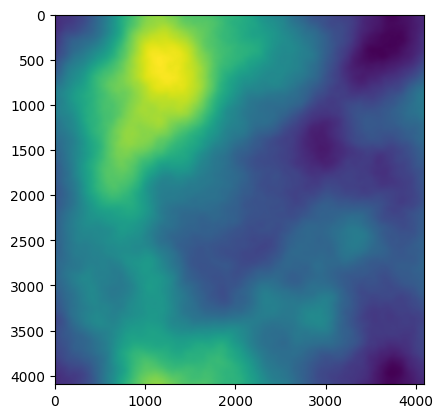

In [7]:
plt.imshow(f)
plt.show()

## 3d field

In [ ]:
# Note: Only 10 first slices are calculated in `dfa_sliced` for speed up.
size = 2**9
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise((size, size, size), hurst=h).real
    res = dfa_sliced(f)[0:10]
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

sliced 3d DFA:   2%|▏         | 11/512 [00:37<28:15,  3.38s/it]


Ht=0.5, Hf Mean +- Std: 0.69 +- 0.04


sliced 3d DFA:   2%|▏         | 11/512 [00:37<28:38,  3.43s/it]


Ht=0.75, Hf Mean +- Std: 0.86 +- 0.05


sliced 3d DFA:   2%|▏         | 11/512 [00:36<28:02,  3.36s/it]


Ht=1.0, Hf Mean +- Std: 1.10 +- 0.05


sliced 3d DFA:   2%|▏         | 11/512 [00:37<28:09,  3.37s/it]


Ht=1.25, Hf Mean +- Std: 1.31 +- 0.06


sliced 3d DFA:   2%|▏         | 11/512 [00:36<27:58,  3.35s/it]

Ht=1.5, Hf Mean +- Std: 1.54 +- 0.04
Field shape is (512, 512, 512)


### Visualisation

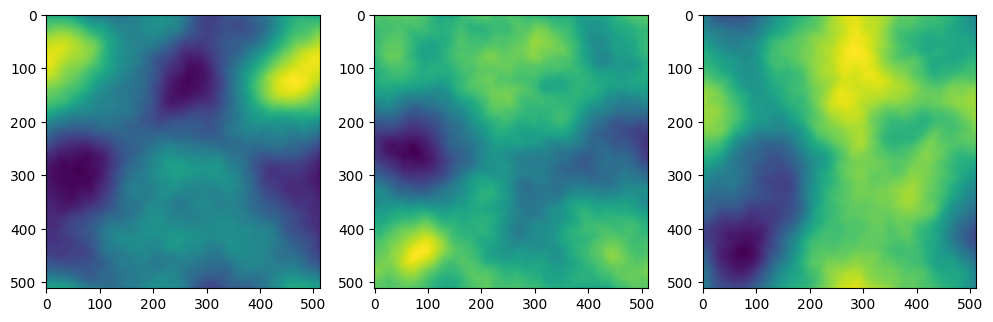

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(f[256, :, :])
ax[1].imshow(f[:, 256, :])
ax[2].imshow(f[:, :, 256])
plt.show()